# Ensemble Methods

Simple models - logistic regression, decision trees, naive bayes - are often easy to interpret, but offer lack power and suffer from either high bias or high variance. One way to address this is gathering a large number of simple models together and aggregate the answers of these models to achieve a better, aggregate answer. In human systems, this has been referred to as the "wisdom of the crowd," and it is one of the underpinnings of Western socio-political organizations, being the fundamental motivation for both democracy and the market.

Ensemble methods, at their core, apply the wisdom of the crowds idea to ML.The intuition is simple: if different models, with their unique strengths and weaknesses, make different errors, then combining them can often average out their errors and yield a better prediction.

#### **Wisdom of the Crowd: A Coin Toss Experiment**

Consider a simple coin toss. If a slightly biased coin has a 51% chance of coming up heads and we toss it a few times, the results could be fairly erratic. It might come up heads 7 times out of 10 or just 3 times out of 10. However, as we toss the coin more and more, the ratio of heads will tend to get closer and closer to the 51%.

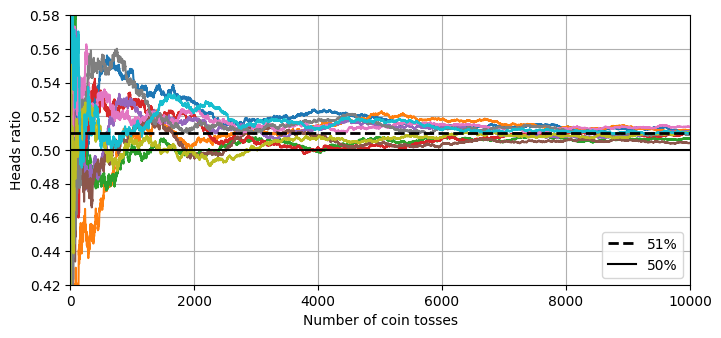

In [2]:
import matplotlib.pyplot as plt
import numpy as np

heads_proba = 0.51
np.random.seed(42)
coin_tosses = (np.random.rand(10000, 10) < heads_proba).astype(np.int32)
cumulative_heads = coin_tosses.cumsum(axis=0)
cumulative_heads_ratio = cumulative_heads / np.arange(1, 10001).reshape(-1, 1)

plt.figure(figsize=(8, 3.5))
plt.plot(cumulative_heads_ratio)
plt.plot([0, 10000], [0.51, 0.51], "k--", linewidth=2, label="51%")
plt.plot([0, 10000], [0.5, 0.5], "k-", label="50%")
plt.xlabel("Number of coin tosses")
plt.ylabel("Heads ratio")
plt.legend(loc="lower right")
plt.axis([0, 10000, 0.42, 0.58])
plt.grid()
plt.show()



As seen in the plot, with a small number of tosses, the ratio can be far from 51%. But as the number of tosses increases, the ratio of heads tends to 51%. This is known as the **Law of Large Numbers**. 

The coin toss experiment gives us a hint towards a fundamental concept in ensemble learning: even if each individual prediction (or coin toss) is weak and unreliable, aggregating predictions can lead to a more robust and accurate result.


### **1. Basic Ensemble Techniques**

#### **Voting Classifiers**

One of the simplest ensemble methods is the Voting Classifier. The idea behind the Voting Classifier is to combine conceptually different machine learning classifiers and use either the majority (hard vote) or the average predicted probabilities (soft vote) to predict the class labels.

- **Hard Voting**: As the name suggests, each individual classifier in the ensemble "votes" for a class, and the class that gets the majority of votes is the prediction of the ensemble.

- **Soft Voting**: Here, every individual classifier provides a probability estimate for each class. The class with the highest average probability across the classifiers is chosen as the prediction.

Soft voting often achieves better results because it gives more weight to highly confident votes.

In [44]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Generating a dataset
X, y = make_moons(n_samples=1000, noise=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# Defining the classifiers
log_clf = LogisticRegression(random_state=42)
svm_clf = SVC(probability=True, random_state=42) # 'probability=True' to enable soft voting
tree_clf = DecisionTreeClassifier(random_state=42)

voting_hard_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('svm', svm_clf), ('tree', tree_clf)],
    voting='hard')
voting_hard_clf.fit(X_train, y_train)

voting_soft_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('svm', svm_clf), ('tree', tree_clf)],
    voting='soft')
voting_soft_clf.fit(X_train, y_train)

# Evaluating classifiers
for clf in (log_clf, svm_clf, tree_clf, voting_hard_clf, voting_soft_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.852
SVC 0.916
DecisionTreeClassifier 0.892
VotingClassifier 0.912
VotingClassifier 0.916


### Exercise

Using the above code, try adding the other classifiers you know about: SGDClassifier, KNN, and NaiveBayes. Do your results improve with more classifiers?

### **2. Bagging (Bootstrap Aggregating)** 

#### **2.1 Principle of Operation** 

Bagging, which stands for **Bootstrap Aggregating**, is an ensemble method that aims to reduce the variance of an estimator by leveraging multiple instances of it. The central idea revolves around the following:

- **Training instances** are randomly sampled **with replacement** from the dataset. This means that the same training instance can be sampled multiple times for one predictor and not at all for another. This method of sampling is termed "bootstrapping."
  
- Every predictor in the ensemble is trained on a different bootstrap sample. This means that different instances of the predictor might be seeing slightly different data during their training.

- Once the predictors are trained, the ensemble can make predictions for a new instance by simply aggregating the predictions of all predictors.
  - The aggregation function is typically the **statistical mode** (i.e., the most frequent prediction) for classification or the **average** for regression.

#### **2.2 Key Features**

- **Inherent parallelism** An essential feature of bagging is that the individual predictors can be trained in parallel, as they are independent of each other, which makes bagging scalable and suitable for distributed computing.
- **Reduction in Variance**: As individual predictors might overfit to their specific bootstrap samples, when predictions from all the predictors are aggregated, the ensemble can generalize better and produce a more stable and accurate result.

- **Maintains Bias**: The bias remains similar to that of a single predictor because each one is trained on data sampled from the entire dataset.

#### **2.3 Bagging with `sklearn`**

`sklearn` provides the `BaggingClassifier`, which automates the process of training multiple instances of a predictor on different subsets of the data.


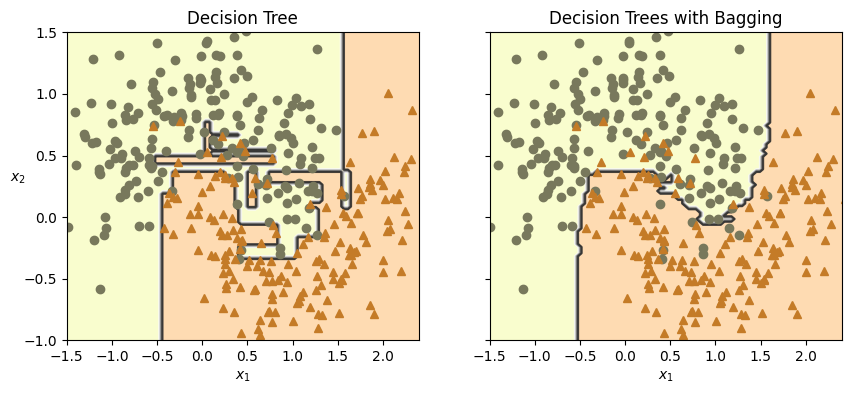

In [45]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            max_samples=100, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)

def plot_decision_boundary(clf, X, y, alpha=1.0):
    axes=[-1.5, 2.4, -1, 1.5]
    x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 100),
                         np.linspace(axes[2], axes[3], 100))
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    
    plt.contourf(x1, x2, y_pred, alpha=0.3 * alpha, cmap='Wistia')
    plt.contour(x1, x2, y_pred, cmap="Greys", alpha=0.8 * alpha)
    colors = ["#78785c", "#c47b27"]
    markers = ("o", "^")
    for idx in (0, 1):
        plt.plot(X[:, 0][y == idx], X[:, 1][y == idx],
                 color=colors[idx], marker=markers[idx], linestyle="none")
    plt.axis(axes)
    plt.xlabel(r"$x_1$")
    plt.ylabel(r"$x_2$", rotation=0)

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(tree_clf, X_train, y_train)
plt.title("Decision Tree")
plt.sca(axes[1])
plot_decision_boundary(bag_clf, X_train, y_train)
plt.title("Decision Trees with Bagging")
plt.ylabel("")
plt.show()


### Exercise

When does it make sense to use a Bagging Classifier?  In the following, explore different data parameters to develop your intuition for which classifier makes sense in which situation. 

1. Gradually increase the noise in the data (using the noise parameter).  How do the different classifiers perform.  Why?


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

X, y = make_moons(n_samples=300, noise=.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)
y_pred_tree = tree.predict(X_test)
y_train_pred_tree = tree.predict(X_train)
print("Decision Tree Accuracy (train):", accuracy_score(y_train, y_train_pred_tree))
print("Decision Tree Accuracy (test):", accuracy_score(y_test, y_pred_tree))



log_reg = LogisticRegression(random_state=42)
log_reg.fit(X_train, y_train)
y_pred_log = log_reg.predict(X_test)
y_train_pred_log = log_reg.predict(X_train)
print("Logistic Regression Accuracy (train):", accuracy_score(y_train, y_train_pred_log))
print("Logistic Regression Accuracy (test):", accuracy_score(y_test, y_pred_log))

2.  Now, do the same thing in the following.  What do you notice. How do you explain your observations?

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score

X, y = make_moons(n_samples=300, noise=.2, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

bag_tree = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, random_state=42)
bag_tree.fit(X_train, y_train)
y_pred_bag = bag_tree.predict(X_test)
print("Bagging Decision Tree Accuracy (test):", accuracy_score(y_test, y_pred_bag))


bag_log = BaggingClassifier(LogisticRegression(), n_estimators=500, random_state=42)
bag_log.fit(X_train, y_train)
y_pred_bag_log = bag_log.predict(X_test)
print("Bagging Logistic Regression Accuracy (test):", accuracy_score(y_test, y_pred_bag_log))

3. Now go back and start increasing the number of samples.  How do things change? 

#### **2.4 Out-of-Bag (OOB) Evaluation:**

When using bagging (like in a Random Forest), some instances may be sampled multiple times for one predictor, while others may not be sampled at all. The ones not sampled for a particular predictor are called "out-of-bag" instances for that predictor.

- **How is it useful?** Since a predictor never sees the OOB instances during training, they can be used to evaluate the predictor's performance without the need for a separate validation set or cross-validation. In essence, each predictor in the ensemble is evaluated using different OOB instances.

- **OOB Score**: `sklearn` has a mechanism where, if you set `oob_score=True` for a bagging classifier, after training, the classifier will automatically compute an OOB score which gives an estimate of the prediction accuracy using the OOB instances.

- **Comparison with Cross-Validation**: While OOB can provide a good performance estimate, cross-validation is generally more robust as it averages performance over multiple train-test splits, giving a more comprehensive view of model stability and performance.

In [ ]:
X, y = make_moons(n_samples=500, noise=.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500,
                            oob_score=True, n_jobs=-1, random_state=42)
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

#### **2.4 Random Forests**

Random Forests are a well-known powerful ML techniques that utilizes Decision Trees with bagging. However, in addition to using different bootstrap samples,  introduces randomness in feature selection when splitting a node. That is, instead of considering all features for a split, a random subset of features is chosen. There are several reasons for this:

1. **Decorrelation of Trees**: One of the primary reasons for introducing randomness in feature selection at each node is to ensure that individual decision trees in the ensemble are not highly correlated. If we always chose the best features for splitting, many of the trees in the ensemble would look similar (especially at the top splits). This would diminish the benefits of ensemble averaging.

2. **Reduced Overfitting**: By considering only a subset of features, we prevent the trees from always splitting on the most dominant features, which can lead to overfitting. Instead, the model is forced to consider other features, leading to more diverse and generalized decision boundaries.

3. **Computational Efficiency**: Evaluating the best split is computationally costly. By considering only a subset of features, the training time for each tree is reduced. Given that Random Forests involve training many trees, this computational saving is significant.

One significant advantage of Random Forest is that it can provide an estimate of the importance of each feature in making accurate predictions.  However, this comes at the cost of interpretability - because a random forest involves many trees, it's very hard to draw any insights (e.g. rules) about how predictions are being made.


**Hyperparameters and Practical Considerations**


- Number of Trees (`n_estimators`): More trees usually result in better performance but with diminishing returns. It also increases computational cost.
- Max Depth (`max_depth`): Controls the depth of the trees. 
- Max Features (`max_features`): The number of features to consider for splitting. Influences decorrelation.
- Minimum Samples Split (`min_samples_split`): Minimum samples required to make a new split.
- Others: `min_samples_leaf`, `bootstrap`, etc.
- The default settings in sklearn's RF implementation often provide a good starting point.

### Exercise

Play with the following example for a few moments to get a sense of how different parameter settings work.  See [the documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) for additional detail on the parameters.

In [83]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=500, max_depth=3, max_features='sqrt', oob_score=True, random_state=42)
rf_clf.fit(X_train, y_train)

# Performance metrics
print(rf_clf.oob_score_)



0.8613333333333333


***Note***: a RandomForestClassifier is identical to a BaggingClassifier with a DecisionTree:

In [86]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features="sqrt", max_leaf_nodes=16),
    n_estimators=500, n_jobs=-1, random_state=42)

rf_clf = RandomForestClassifier(n_estimators=500, max_features='sqrt', max_leaf_nodes=16, random_state=42)


# extra code – verifies that the predictions are identical
bag_clf.fit(X_train, y_train)
rf_clf.fit(X_train,y_train)
y_pred_bag = bag_clf.predict(X_test)
y_pred_rf = rf_clf.predict(X_test)
np.all(y_pred_bag == y_pred_rf)  # same predictions

True

#### 2.4.1 Feature Importance with Random Forests

Feature importance is a key benefit of Random Forests, as it provides insight into which features are the most influential in making predictions. Understanding feature importance can help in feature engineering, feature selection, and interpreting the model.  The Random Forest API makes it easy to inspect feature importance, as follows.

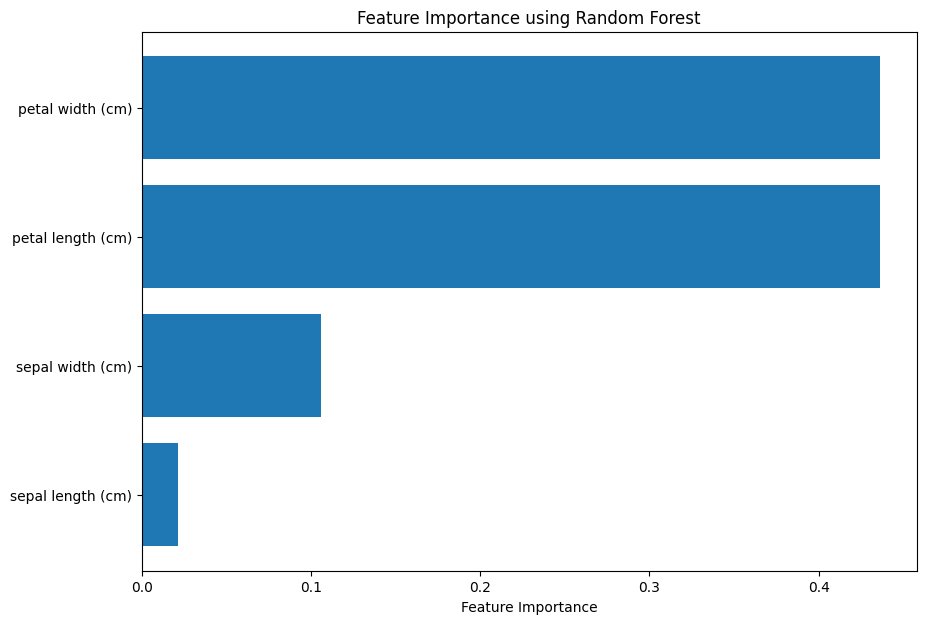

In [87]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier

# Load the data
iris = load_iris()
X = iris.data
y = iris.target

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

importances = rf.feature_importances_

# Get the indices of the features sorted by importance
sorted_idx = np.argsort(importances)

plt.figure(figsize=(10, 7))
plt.barh(range(X.shape[1]), importances[sorted_idx], align='center')
plt.yticks(range(X.shape[1]), iris.feature_names)
plt.xlabel('Feature Importance')
plt.title('Feature Importance using Random Forest')
plt.show()



If you have a high-dimensional dataset, Random Forest's feature importance can be used to select a subset of the most influential features. This can speed up training and even improve model performance if there are noisy or redundant features.

In [98]:
from sklearn.feature_selection import SelectFromModel
import pandas as pd

# Create a selector object
sfm = SelectFromModel(rf, threshold=0.25)  # only select features with an importance > 0.25
sfm.fit(X, y)

selected_mask = sfm.get_support()

# Extracting the indices of the selected features
selected_indices = np.where(selected_mask)[0]


X_transformed = sfm.transform(X)
pd.DataFrame(X_transformed,columns =np.array(iris.feature_names)[selected_indices])

,petal length (cm),petal width (cm)
0,1.4,0.2
1,1.4,0.2
2,1.3,0.2
3,1.5,0.2
4,1.4,0.2
...,...,...
145,5.2,2.3
146,5.0,1.9
147,5.2,2.0
148,5.4,2.3


This can be particularly instructive when processing data with a visual interpretation.  For example:

/Users/jeintron/Dropbox/@TEACHING/2023/FALL23/DEV/ist407-707.venv/lib/python3.10/site-packages/sklearn/datasets/_openml.py:1002: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


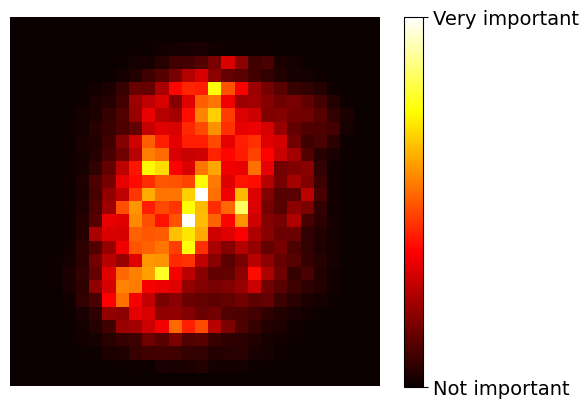

In [99]:
# 1.5 minutes to run!

from sklearn.datasets import fetch_openml

X_mnist, y_mnist = fetch_openml('mnist_784', return_X_y=True, as_frame=False)

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(X_mnist, y_mnist)

heatmap_image = rnd_clf.feature_importances_.reshape(28, 28)
plt.imshow(heatmap_image, cmap="hot")
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(),
                           rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'], fontsize=14)
plt.axis("off")
plt.show()

0.904